<a href="https://colab.research.google.com/github/kaneelgit/msi_voxceleb/blob/main/Multimodal_classification_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size = '6'> <center>**Multimodal Classification**</center></font>

Here I am using a multimodal approach. I will be using both video and audio data for gender classification. The videos feature extraction will be done by a 3D CNN model as before and the audio classification will be done by a 2D classification model as before. 

VoxCeleb dataset - https://www.robots.ox.ac.uk/~vgg/data/voxceleb/

In [2]:
#import libraries
from urllib.request import urlopen
from zipfile import ZipFile

from IPython.display import HTML
from base64 import b64encode
import matplotlib.pyplot as plt

import os
import glob
import numpy as np
import pandas as pd
import cv2     # for capturing videos
import math
import random

import moviepy.editor as mp
from IPython.display import clear_output

import IPython
import librosa

from scipy.io import wavfile
import os
import tensorflow as tf

# **Download and unzip the data**

In [2]:
#get url
!wget "https://thor.robots.ox.ac.uk/~vgg/data/voxceleb/vox1a/vox2_test_mp4.zip"

--2021-10-27 20:45:04--  https://thor.robots.ox.ac.uk/~vgg/data/voxceleb/vox1a/vox2_test_mp4.zip
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8906971319 (8.3G) [application/zip]
Saving to: ‘vox2_test_mp4.zip’

vox2_test_mp4.zip   100%[===================>]   8.29G  25.7MB/s    in 4m 57s  

2021-10-27 20:50:02 (28.6 MB/s) - ‘vox2_test_mp4.zip’ saved [8906971319/8906971319]



In [3]:
!unzip vox2_test_mp4.zip

Streaming output truncated to the last 5000 lines.
  inflating: mp4/id05999/tZe9RtGYPu8/00255.mp4  
  inflating: mp4/id05999/tZe9RtGYPu8/00257.mp4  
  inflating: mp4/id05999/tZe9RtGYPu8/00264.mp4  
  inflating: mp4/id05999/tZe9RtGYPu8/00266.mp4  
  inflating: mp4/id05999/tZe9RtGYPu8/00268.mp4  
  inflating: mp4/id05999/tZe9RtGYPu8/00260.mp4  
  inflating: mp4/id05999/tZe9RtGYPu8/00259.mp4  
  inflating: mp4/id05999/tZe9RtGYPu8/00270.mp4  
  inflating: mp4/id05999/tZe9RtGYPu8/00269.mp4  
  inflating: mp4/id05999/tZe9RtGYPu8/00267.mp4  
  inflating: mp4/id05999/tZe9RtGYPu8/00256.mp4  
   creating: mp4/id05999/U8TaxVpPsSg/
  inflating: mp4/id05999/U8TaxVpPsSg/00160.mp4  
  inflating: mp4/id05999/U8TaxVpPsSg/00162.mp4  
  inflating: mp4/id05999/U8TaxVpPsSg/00159.mp4  
  inflating: mp4/id05999/U8TaxVpPsSg/00161.mp4  
   creating: mp4/id05999/crh0LREMv-8/
  inflating: mp4/id05999/crh0LREMv-8/00196.mp4  
  inflating: mp4/id05999/crh0LREMv-8/00194.mp4  
  inflating: mp4/id05999/crh0LREMv-8/001

# **Organizing the data**

In the cells below I am collecting all the video paths in a list. I will be then using these videos to extract the audios and their spectrograms to feed in to the neural network.

In [6]:
#get video paths
vid_paths = []

for path, directories, files in os.walk('/content/mp4/'):

  for file in files:

    vid_paths.append(str(path) + '/' + str(file))

#number of videos available
print('Number of videos available: ', len(vid_paths))

#shuffle video paths. I have used a random seed of 4 to shuffle.
random.seed(3)
random.shuffle(vid_paths)

Number of videos available:  36237


# **Upload the CSV file and clean meta data**


The csv file with meta data is in my github repository. (https://github.com/kaneelgit/msi_voxceleb). You have to upload the csv file to colab before running the following cells.

In [7]:
#some functions to clean the csv file
#del spaces from the ids and gender
def del_spaces(string):
  
  string = string.replace(' ', '')

  return string

#upload csv file from github before running
#open csv file
df = pd.read_csv('/content/vox2_meta.csv')
df.head(5)

#clean the dataset

#apply the function to get rid of spaces
df['VoxCeleb2 ID'] = df['VoxCeleb2 ID'].apply(del_spaces)
df['VGGFace2 ID'] = df['VGGFace2 ID'].apply(del_spaces)
df['Gender'] = df['Gender'].apply(del_spaces)
df['Set'] = df['Set'].apply(del_spaces)


#get the test data
df2 = df[df['Set'] == 'test']
df2['Gender'] = df2['Gender'].astype('category')

df2.head(5)

,VoxCeleb2 ID,VGGFace2 ID,Gender,Set
3,id00017,n000017,m,test
36,id00061,n000061,m,test
53,id00081,n000081,m,test
89,id00154,n000154,m,test
271,id00419,n000419,f,test


# **Create a Labels List**

Here I am going through the ids of all the video files and picking the gender from the CSV file. Note that there are double the size of male videos compared to female. So I will be taking every other video file to balance the dataset.

In [8]:
#iterate through the vid_paths get the id of the person and get if the person is female or male. If the person is male its a 1 and female its a 0
labels = []

#get only half of the male videos.
count = 0
video_files = []

#iterate
for path in vid_paths:
  
  #get id number
  id_str =  path[13:20]

  #get if the subject is male or female from the csv
  gender = df2.loc[df2['VoxCeleb2 ID'] == str(id_str)]['Gender'].values[0]

  if gender == 'm':
    if count % 2 == 0:
      labels.append(1)
      video_files.append(path)
    count += 1
  
  else:
    labels.append(0)
    video_files.append(path)

# **Create a data generator**

Here I am creating a data generator to feed audio and video data to the model. 

In [50]:
def data_generator(dataset, batch_size = 16):

  while True:
   
    #create empby batch to initialize
    video_batch = np.zeros([batch_size, 224, 224, 3])
    audio_batch = np.zeros([batch_size, 128, 259, 1])
    label_batch = np.zeros([batch_size, 1])
    count = 0

    for i, (x, y, z) in enumerate(dataset):

      video_batch[count, :, :, :] = x
      audio_batch[count, :, :, :] = y
      label_batch[count, :] = z.numpy()
      count += 1

      if (i + 1) % batch_size == 0:
        yield {'video': video_batch, 'audio': audio_batch}, {'class': label_batch}

        #reinitialize count and arrays
        video_batch = np.zeros([batch_size, 224, 224, 3])
        audio_batch = np.zeros([batch_size, 128, 259, 1])
        label_batch = np.zeros([batch_size, 1])
        count = 0



In [51]:
def convert_data(path):

  #convert path to string from tensor
  path = path.numpy().decode('utf-8')

  #get label
  id_str =  path[13:20]

  #get if the subject is male or female from the csv
  gender = df2.loc[df2['VoxCeleb2 ID'] == str(id_str)]['Gender'].values[0]

  label = 1 if gender == 'm' else 0

  #video processing
  video = mp.VideoFileClip(path).subclip(0, 3)

  #imag
  imag = video.get_frame(0)/255

  #audio processing
  audio = video.audio.to_soundarray()

  #sampling rate
  fs = 44100
  
  #channel 1
  ch1 = librosa.feature.melspectrogram(audio[:, 0], sr = fs)
  mel_ch1 = librosa.amplitude_to_db(ch1, ref = np.min)

  return imag, mel_ch1.reshape(mel_ch1.shape[0], mel_ch1.shape[1], 1), label


In [52]:
def convert_val_data(path):

  #get label
  id_str =  path[13:20]

  #get if the subject is male or female from the csv
  gender = df2.loc[df2['VoxCeleb2 ID'] == str(id_str)]['Gender'].values[0]

  label = 1 if gender == 'm' else 0

  #video processing
  video = mp.VideoFileClip(path).subclip(0, 3)

  #imag
  imag = video.get_frame(0)/255

  #audio processing
  audio = video.audio.to_soundarray()

  #sampling rate
  fs = 44100
  
  #channel 1
  ch1 = librosa.feature.melspectrogram(audio[:, 0], sr = fs)
  mel_ch1 = librosa.amplitude_to_db(ch1, ref = np.min)

  return imag, mel_ch1.reshape(mel_ch1.shape[0], mel_ch1.shape[1], 1), label

# **Train/validation split**

Here I have manually seperated the train and validation set because I ran into memory issues in colab.

In [53]:
#split to train and validation set
train_idx = int(np.floor(len(labels[:1800]) * 0.9))

#split the train and test data accordingly
train_paths = video_files[:train_idx]
train_labels = labels[:train_idx]

#split the test data
val_paths = video_files[train_idx:1800]
val_labels = labels[train_idx:1800]

In [54]:
#validation set
validation_set_vid = np.zeros([150, 224, 224, 3])
validation_set_aud = np.zeros([150, 128, 259, 1])
validation_labels = np.zeros([150, 1])

#select 100 random indexes from the validation set
#rand_val_idx = np.random.choice(np.arange(len(val_paths)), 150)
rand_val_idx = np.arange(len(val_paths[:150]))

for i, idx in enumerate(rand_val_idx):

  #vid path
  path = val_paths[idx]

  validation_set_vid[i, :], validation_set_aud[i, :], label = convert_val_data(path)
  validation_labels[i, :] = label

In [56]:
#training set
#validation set
training_set_vid = np.zeros([1600, 224, 224, 3])
training_set_aud = np.zeros([1600, 128, 259, 1])
training_labels = np.zeros([1600, 1])

#select 100 random indexes from the validation set
#rand_val_idx = np.random.choice(np.arange(len(val_paths)), 150)
rand_train_idx = np.arange(len(train_paths[:1600]))

for i, idx in enumerate(rand_train_idx):

  #vid path
  path = train_paths[idx]

  training_set_vid[i, :], training_set_aud[i, :], label = convert_val_data(path)
  training_labels[i, :] = label

KeyboardInterrupt: ignored

In [12]:
#training datset
training_dataset = tf.data.Dataset.list_files(train_paths)
training_dataset = training_dataset.map(lambda x: tf.py_function(convert_data, [x], (tf.float32, tf.float32, tf.int32))).prefetch(tf.data.AUTOTUNE)


In [57]:
del training_set_vid

# **Multimodal Architecture**

Here I create a multimodal architecture to use both audio and video data for classification


In [42]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Average, Activation, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.keras.utils.vis_utils import plot_model

In [43]:
#3d cnn for video
def cnn_3dmodel(x):
    
    inputs = x
    x = tf.keras.layers.Conv2D(16, kernel_size = (3, 3), activation = 'relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size = (2, 2))(x)
    
    x = tf.keras.layers.Conv2D(32, kernel_size = (3, 3), activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size = (2, 2))(x)
    
    x = tf.keras.layers.Conv2D(64, kernel_size = (6, 6), activation = 'relu')(x) 
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size = (2, 2))(x)

    return x

#video inp
input_video_tmp = np.zeros([16, 224, 224, 3])

#creat video layers
input_vid = Input(input_video_tmp[0, :].shape, name = 'video')
out_vid = cnn_3dmodel(input_vid)
out_vid = Flatten()(out_vid)
out_vid = Dropout(0.5)(out_vid)
out_vid = Dense(1024, activation = 'relu')(out_vid)
# out_vid = Dense(128, activation = 'relu')(out_vid)
output_video = Dense(1, activation = 'sigmoid', name = 'video_class')(out_vid)


In [45]:
#2d cnn for audio
def cnn_2dmodel(x):
    
    inputs = x
    x = tf.keras.layers.Conv2D(16, kernel_size = (3, 3),activation = 'relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size = (2, 2))(x)
    
    x = tf.keras.layers.Conv2D(32, kernel_size = (3, 3), activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size = (2, 2))(x)
    
    x = tf.keras.layers.Conv2D(64, kernel_size = (6, 6), activation = 'relu')(x) 
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size = (2, 2))(x)

    return x

#create audio layers
input_audio_tmp = np.zeros([16, 128, 259, 1])
input_aud = Input(input_audio_tmp[0, :].shape, name = 'audio')
out_aud = cnn_2dmodel(input_aud)
out_aud = Flatten()(out_aud)
out_aud = Dropout(0.5)(out_aud)
out_aud = Dense(1024, activation = 'relu')(out_aud)
out_aud = Dropout(0.8)(out_aud)
# out_aud = Dense(128, activation = 'relu')(out_aud)
output_audio = Dense(1, activation = 'sigmoid', name = 'audio_class')(out_aud)


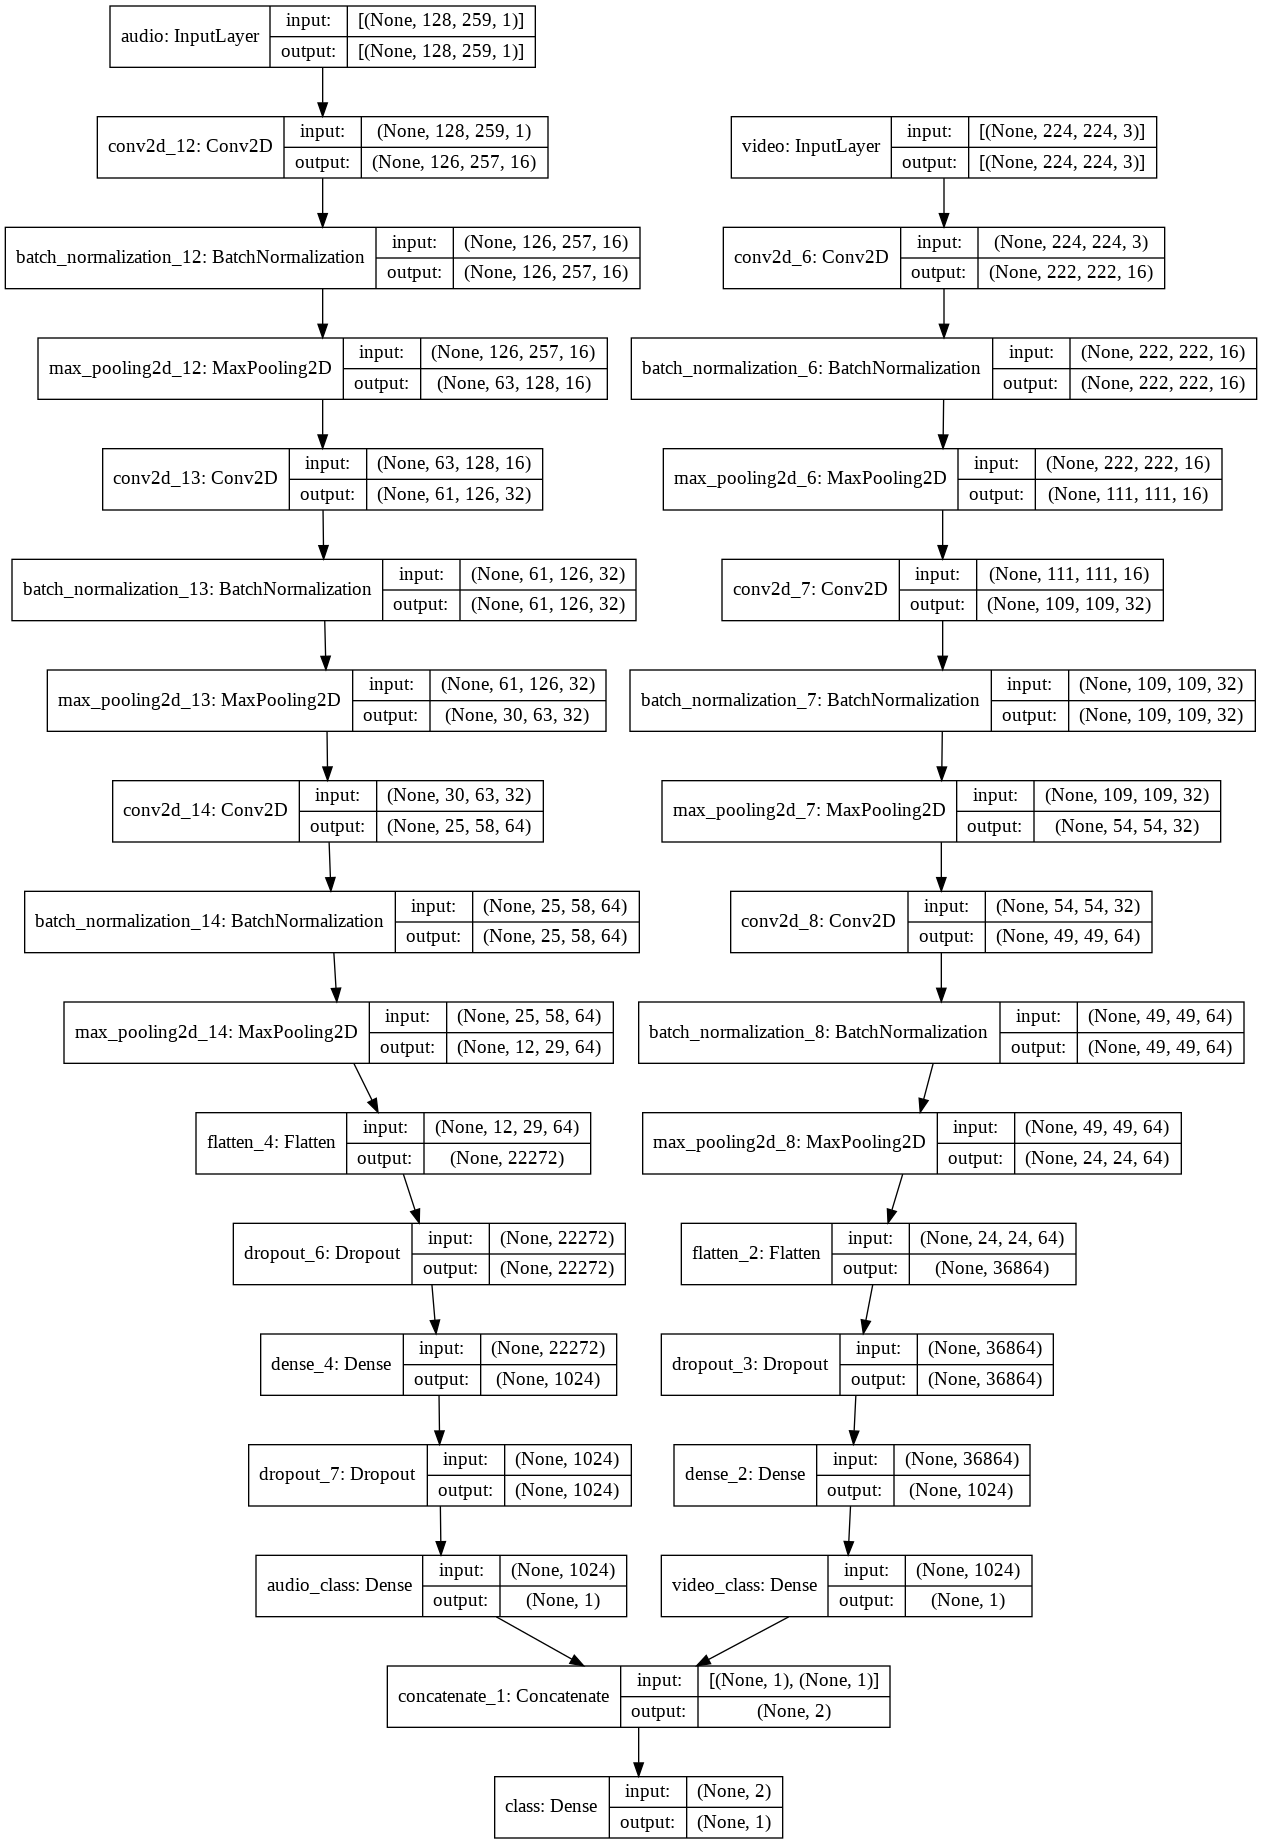

In [46]:
#create the combined model
combined_out = tf.keras.layers.Concatenate(axis=1)([output_video, output_audio])
combined_out = Dense(1, activation = 'sigmoid', name = 'class')(combined_out)
combined_model = Model([input_vid, input_aud], combined_out)

#plot the combined model
plot_model(combined_model, show_shapes = True, show_layer_names = True, to_file = 'test_model.png')

In [47]:
combined_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
audio (InputLayer)              [(None, 128, 259, 1) 0                                            
__________________________________________________________________________________________________
video (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 126, 257, 16) 160         audio[0][0]                      
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 222, 222, 16) 448         video[0][0]                      
____________________________________________________________________________________________

In [20]:
#compile the model
opt = tf.optimizers.Adam(0.001)

#learning rate scheduler
def lr_schedule(epoch, lr):
    
    if (epoch + 1) % 5 == 0:
        
        lr *= 0.2
    
    return max(lr, 3e-7)

opt = tf.keras.optimizers.SGD(
    learning_rate=0.01, momentum=0.0, nesterov=False, name='SGD')

#compile model
combined_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = 'accuracy')

# #memory test
# import resource
# class MemoryCallback(Callback):
#     def on_epoch_end(self, epoch, log={}):
#         print(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)

#callbacks
#create a callback to stop the model when loss hit plateur
cb = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 5, mode = 'auto')

cb_lr = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

#fit model
# history = combined_model.fit(data_generator(train_paths, train_labels, batch_size = 16), validation_data = ([validation_set_vid, validation_set_aud], validation_labels),\
#                     steps_per_epoch = 50, epochs = 10, callbacks = [cb, cb_lr])

# history = combined_model.fit([training_set_vid, training_set_aud], training_labels, validation_data = ([validation_set_vid, validation_set_aud], validation_labels),\
#                              epochs = 10, callbacks = [cb, cb_lr])

# history = combined_model.fit(data_generator(training_dataset, batch_size = 16), epochs = 10, steps_per_epoch = 100, validation_data = ([validation_set_vid, validation_set_aud], validation_labels))

history = combined_model.fit([training_set_vid, training_set_aud], training_labels, epochs = 10, validation_data = ([validation_set_vid, validation_set_aud], validation_labels))

Epoch 1/10
50/50 [==============================] - 40s 162ms/step - loss: 0.6298 - accuracy: 0.9112 - val_loss: 0.7083 - val_accuracy: 0.4467
Epoch 2/10
50/50 [==============================] - 7s 145ms/step - loss: 0.5857 - accuracy: 0.9431 - val_loss: 0.6997 - val_accuracy: 0.4867
Epoch 3/10
50/50 [==============================] - 7s 144ms/step - loss: 0.5740 - accuracy: 0.8275 - val_loss: 0.6864 - val_accuracy: 0.5600
Epoch 4/10
50/50 [==============================] - 7s 144ms/step - loss: 0.5376 - accuracy: 0.8850 - val_loss: 0.6935 - val_accuracy: 0.5267
Epoch 5/10
50/50 [==============================] - 7s 144ms/step - loss: 0.4843 - accuracy: 0.9438 - val_loss: 0.6923 - val_accuracy: 0.5267
Epoch 6/10
50/50 [==============================] - 7s 144ms/step - loss: 0.4568 - accuracy: 0.9438 - val_loss: 0.6918 - val_accuracy: 0.5267
Epoch 7/10
50/50 [==============================] - 7s 145ms/step - loss: 0.4316 - accuracy: 0.9438 - val_loss: 0.6918 - val_accuracy: 0.5267
Epoch

(array([1510.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          90.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

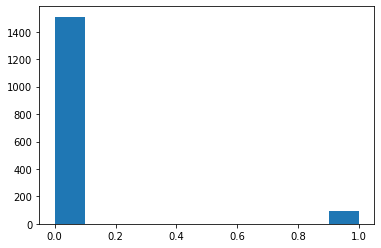

In [28]:
plt.hist(training_labels)

(array([761.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 839.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

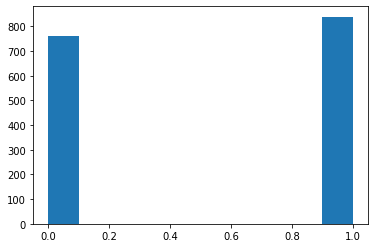

In [32]:
plt.hist(labels[:1600])

In [34]:
rand_val_idx

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179])